# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [2]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))

    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [3]:
%%time
init_num_chains = 50
model = hierarchical_model(data, county_idx)
pm4_trace, _ = pm.inference.sampling.sample(
    model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)

CPU times: user 52.6 s, sys: 371 ms, total: 53 s
Wall time: 53.2 s


### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [4]:
%%time
for i in range(3):
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
        step_size=step_size_, xla=True)

CPU times: user 2min 57s, sys: 830 ms, total: 2min 58s
Wall time: 2min 58s


Finally get samples for inference:

In [5]:
%%time
num_chains = 5
step_size_ = []
for _, x in pm4_trace.items():
    std = tf.math.reduce_std(x, axis=[0, 1])
    step_size_.append(
        std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

pm4_trace, sample_stat = pm.inference.sampling.sample(
    model, num_chains=num_chains, num_samples=500, burn_in=500,
    step_size=step_size_, xla=True)

CPU times: user 1min 6s, sys: 244 ms, total: 1min 6s
Wall time: 1min 6s


In [6]:
az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)

In [7]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.7529877 , 0.9221607 , 0.99537736, 0.8030897 , 0.4465725 ],
      dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

/home/junpenglao/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/junpenglao/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


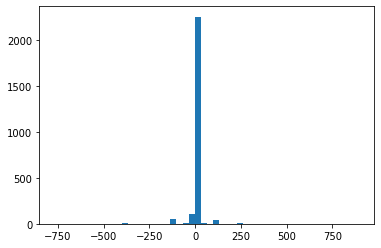

In [8]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [9]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/mu_alpha,1.488,0.048,1.401,1.581,0.002,0.001,666.0,666.0,654.0,1649.0,1.01
hierarchical_model/mu_beta,-0.646,0.082,-0.789,-0.481,0.005,0.003,308.0,308.0,304.0,824.0,1.02
hierarchical_model/alpha[0],1.220,0.244,0.747,1.670,0.006,0.005,1430.0,1351.0,1412.0,1334.0,1.00
hierarchical_model/alpha[1],0.986,0.099,0.811,1.173,0.003,0.002,862.0,862.0,872.0,1233.0,1.00
hierarchical_model/alpha[2],1.492,0.270,1.008,2.021,0.009,0.006,913.0,913.0,905.0,356.0,1.01
hierarchical_model/alpha[3],1.555,0.220,1.128,1.949,0.005,0.004,1813.0,1813.0,1817.0,1189.0,1.00
hierarchical_model/alpha[4],1.450,0.246,1.023,1.938,0.006,0.004,1749.0,1727.0,1727.0,1335.0,1.01
hierarchical_model/alpha[5],1.501,0.247,1.044,1.942,0.009,0.006,781.0,780.0,774.0,909.0,1.01
hierarchical_model/alpha[6],1.861,0.172,1.553,2.177,0.007,0.005,624.0,600.0,646.0,743.0,1.01
hierarchical_model/alpha[7],1.700,0.254,1.253,2.189,0.010,0.008,604.0,556.0,628.0,466.0,1.01


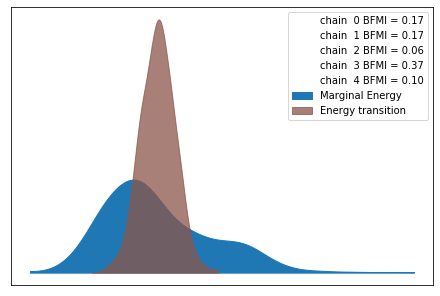

In [10]:
az.plot_energy(az_trace);

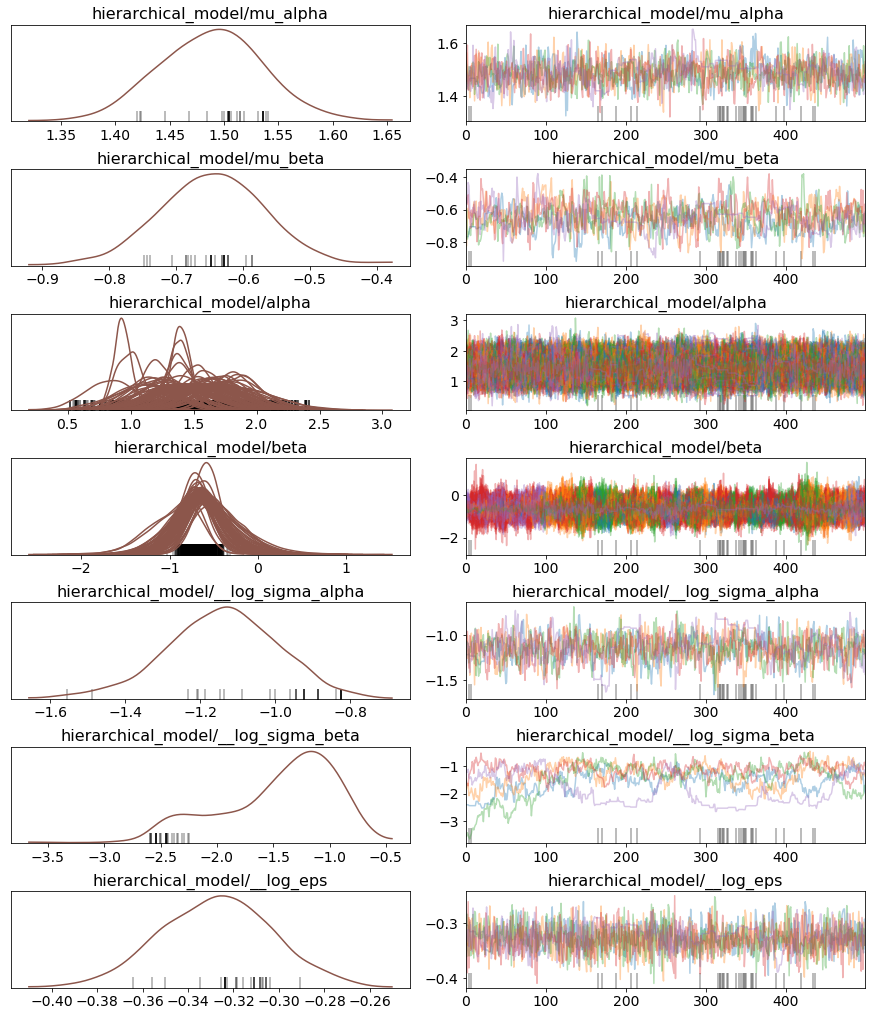

In [11]:
az.plot_trace(az_trace, compact=True, combined=True);